# Truck 1: GPS Speed vs. Wheel-Based Speed

#### Imports and global variables are defined here.

In [48]:
# Imports required for this notebook.
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns

# Local path to the CSV file containing the data for truck two (2).
truckOnePath = "../data/trucks/truck1.csv"

#### Functions are defined here.

In [2]:
"""Uses Pandas's read_csv method to read a CSV file and returns a DataFrame of it to the notebook.
This function reads in all rows and defines the header row at index 0 by default."""
def readCsv(truck, records = None, headerIdx = 0):
    return pd.read_csv(truck, nrows = records, header = [headerIdx])

##### GPS Speed vs. Wheel-Based Speed

Reading in the truck data; one can change how many records are read by using "records = <#>" in the readCsv function or remove it entirely to read all records.

In [3]:
truckOneDf = readCsv(truckOnePath)
truckOneDf = truckOneDf.ffill().bfill()
#truckOneDf.head()

In [4]:
truckOneDf['GPS speed'].describe()

count    1.216689e+06
mean     7.454506e+01
std      3.193598e+01
min      0.000000e+00
25%      6.685720e+01
50%      9.260000e+01
75%      9.297040e+01
max      1.220468e+02
Name: GPS speed, dtype: float64

As we can see, the average GPS Speed is ~ 74.55 km/hr (~ 46.32 mph) with a standard deviation of ~ 31.94 km/hr (~ 19.846596 mph).

In [5]:
truckOneDf['WheelBasedVehicleSpeed'].describe()

count    1.216689e+06
mean     7.483046e+01
std      3.195620e+01
min      0.000000e+00
25%      6.731641e+01
50%      9.293750e+01
75%      9.312891e+01
max      1.213672e+02
Name: WheelBasedVehicleSpeed, dtype: float64

For the wheel-based speed, the average speed is ~ 74.83 km/hr (~ 46.50 mph) with a standard deviation of ~ 31.96 km/hr (~ 19.86 mph)

Let's look at some visualizations to see what's going on.

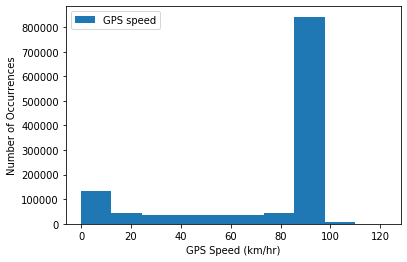

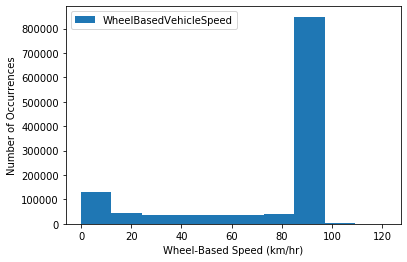

In [6]:
columns = ['GPS speed', 'WheelBasedVehicleSpeed']
gpsSpeedHist = truckOneDf[['GPS speed']].plot.hist(stacked = True)
gpsSpeedHist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedHist.set_ylabel('Number of Occurrences')

wheelSpeedHist = truckOneDf[['WheelBasedVehicleSpeed']].plot.hist(stacked = True)
wheelSpeedHist.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedHist.set_ylabel('Number of Occurrences')

gpsSpeedHist
wheelSpeedHist

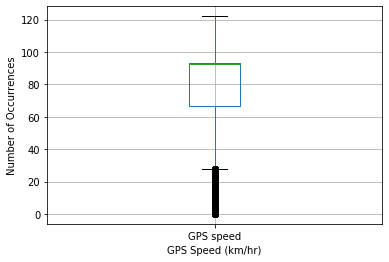

In [7]:
gpsSpeedBox = truckOneDf[['GPS speed']].boxplot()
gpsSpeedBox.set_xlabel('GPS Speed (km/hr)')
gpsSpeedBox.set_ylabel('Number of Occurrences')

gpsSpeedBox

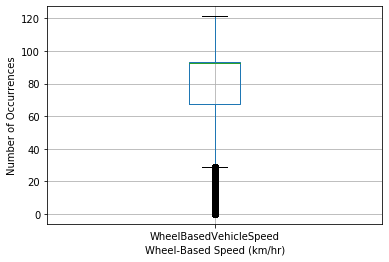

In [8]:
wheelSpeedBox = truckOneDf[['WheelBasedVehicleSpeed']].boxplot()
wheelSpeedBox.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedBox.set_ylabel('Number of Occurrences')

wheelSpeedBox

It's clear that both of these components have a similar trend; there is also definitely a skewness to them. Both of these measurements do have the same axis and appear to be configured correctly.

We can also see that there is a fair amount of readings near zero. We hypothesize that these values are from moments of inactivity, such as stopping at a light or leaving the truck on without moving. Outlier detection is currently being developed and will hopefully snuff these values out.

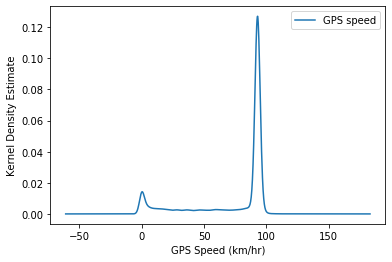

In [9]:
gpsSpeedDist = truckOneDf[['GPS speed']].plot.kde()
gpsSpeedDist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedDist.set_ylabel('Kernel Density Estimate')

gpsSpeedDist

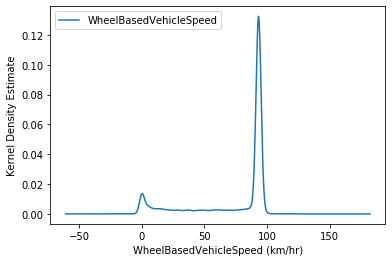

In [10]:
wheelSpeedDist = truckOneDf[['WheelBasedVehicleSpeed']].plot.kde()
wheelSpeedDist.set_xlabel('WheelBasedVehicleSpeed (km/hr)')
wheelSpeedDist.set_ylabel('Kernel Density Estimate')

wheelSpeedDist

At this point, since we haven't removed outliers or the movements of zero (stopped), there are about two peaks which means that the raw data is showing bimodal trends. This would typically indicate that there are two groups within the data set; this data could technically have two groups: a stopped state and a moving state, where stopped represents all of the points near zero and the moving state represents all of the points near the right peak.

Based on what the raw data contains, it appears that this truck does not reach 0 km/hr very often. This could indicate that truck 1 is the "long-haul" truck. This would be logical because of the relatively high speed in such high quantity in the rightmost peak as compared to the very small leftmost peak near zero (0) would be explained by being on an interstate for long periods of time.

Let's take a look at the difference between the GPS Speed and Wheel-Based Speed.

In [11]:
gpsVsWheelBasedChange = truckOneDf['Difference'] = truckOneDf['GPS speed'].sub(truckOneDf['WheelBasedVehicleSpeed'])
gpsVsWheelBasedChange.max()
gpsVsWheelBasedChange.describe()

count    1.216689e+06
mean    -2.853981e-01
std      1.710285e+00
min     -3.774998e+01
25%     -6.849365e-01
50%     -2.984390e-01
75%      0.000000e+00
max      2.738803e+01
dtype: float64

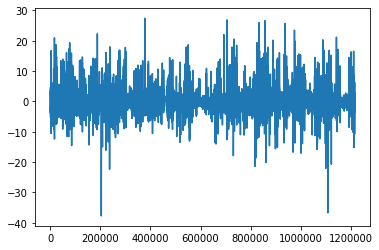

In [12]:
gpsVsWheelBasedChange.plot()

These readings are in regards from GPS Speed to Wheel-Based. I.e., if there is a negative value then it means the GPS Speed was reading lower than the Wheel-Based Speed and if there is a positive value it means the GPS Speed was reading higher than Wheel-Based Speed.

As we can see, it's difficult to tell if there is a significant difference between the two components' measuring capabilities. Thus, we should perform formal hypothesis testing.

##### Hypothesis Testing

We want to know if there is a significant difference between Truck 1's GPS Speed and Wheel-Based Vehicle Speed measurements. To do this, we will set up our two hypotheses:
- $H_{0}:$ Both mean speeds are similar.
- $H_{a}:$ Both mean speeds have a significant difference.

Due to the distributions being bimodal and the difference plot barely being a distribution, we can use the Central Limit Theorem (code based on Dr. Mohanty's code in Lecture 06, Slide Set 4) in order to have some normal data to work with. It is calculating the mean of the means of multiple samples from the data to calculate these curves.

Since there are two samples, we can perform a two-sample t-test with resulting normal distributions from the CLT. 

###### GPS Speed (post-CLT)

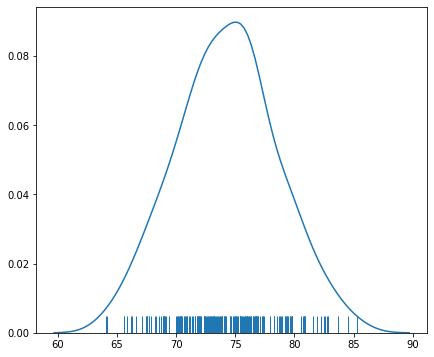

In [67]:
# Create empty list for point estimates.
pointEstimatesGPS = []

# Runs through GPS Speed to get 200 samples, each of size 50.
for x in range(200):
    sample = np.random.choice(a = truckOneDf['GPS speed'], size=50)
    pointEstimatesGPS.append(sample.mean())
    
# Set up distribution graph size.
f, ax = plt.subplots(figsize=(7, 6))

# Plot post-CLT distribution of GPS Speed.
meansOfGPS = sns.distplot(pointEstimatesGPS, hist=False, rug=True);
meansOfGPS

###### Wheel-Based Vehicle Speed (post-CLT)

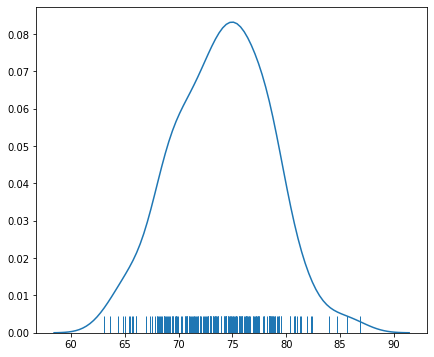

In [70]:
# Create empty list for point estimates.
pointEstimatesWheel = []

# Runs through Wheel-Based Vehicle Speed to get 200 samples, each of size 50.
for x in range(200):
    sample = np.random.choice(a = truckOneDf['WheelBasedVehicleSpeed'], size=50)
    pointEstimatesWheel.append(sample.mean())
    
# Set up distribution graph size.
f, ax = plt.subplots(figsize=(7, 6))

# Plot post-CLT distribution of Wheel-Based Vehicle Speed.
meansOfWheel = sns.distplot(pointEstimatesWheel, hist=False, rug=True); # Plot sample mean density
meansOfWheel

With these two approximately normal distributions, we can perform our two-sample t-test. This will be performed at a confidence level of 95% with an alpha value of 0.05. We will not be assuming equal variance.

In [71]:
stats.ttest_ind(a = pointEstimatesGPS, b = pointEstimatesWheel, equal_var = False)

Ttest_indResult(statistic=0.5068109121220089, pvalue=0.6125689000122868)

As we can see, the p-value is higher than the 0.05 alpha level. Thus, we fail to reject the null hypothesis and can conclude that there is no significant difference between the two means of speeds.

This concludes the initial analysis of GPS Speed and WheelBasedVehicleSpeed for Truck 1.